In [53]:
!pip install scanpy loompy umap-learn scrublet louvain > _

In [26]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import scrublet as scr
import loompy
import os

In [130]:
adata=sc.read_h5ad('Toy_data.h5ad')

# How many cells are in the dataset?
### **5887/**2345/412/7842

In [131]:
adata.n_obs

5887

# How many genes are in the dataset?
### 28212/**126/**2530/386

In [132]:
adata.n_vars


126

# How many samples are in the dataset?
### 4/15/**10**/20

In [133]:
len(adata.obs.Sample_name.value_counts())

10

In [134]:
adata.obs.Sample_name.value_counts()

C7     954
D4     913
D6     785
C10    755
D3     633
D8     602
D1     529
D9     337
D2     261
D5     118
Name: Sample_name, dtype: int64

# How many would you discard based on the QC features?
### 2/**12/**5/18

cuántas células hay? qué porcentaje descartarías por QC? cuántos clusters hay? cuántas muestras son de hombres, cuántas de mujeres?.

In [135]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = adata.var_names.str.startswith('mt-')
adata.obs['mt_frac'] = np.squeeze(np.asarray(adata.X[:, mt_gene_mask].sum(1)))/adata.obs['n_counts']

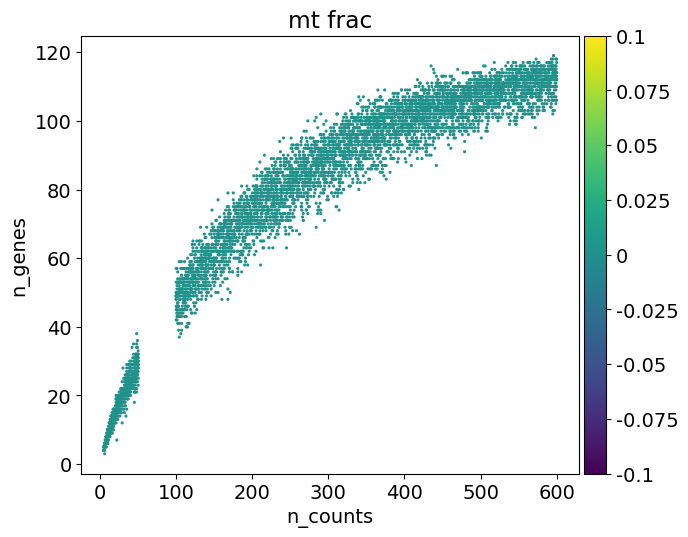

In [136]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')


In [137]:
adata[adata.obs.n_counts<100].n_obs/adata.n_obs*100

11.788686937319518

# How many PCs seem to be relevant?
# hint: remember to APPLY the QC criteria, no need to normalize nor log-transform
# hint: consider ~20% of genes as highly variable
### 15/**8/**2/21

In [138]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 100) #Playing conservative with this one
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 50000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 40) # Would go for 1000 but might cut out too many cells
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_genes = 7000) # Would go for 1000 but might cut out too many cells
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 5887
Number of cells after min count filter: 5193
Number of cells after max count filter: 5193
Number of cells after gene filter: 5189
Number of cells after gene filter: 5189


In [140]:
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=25)

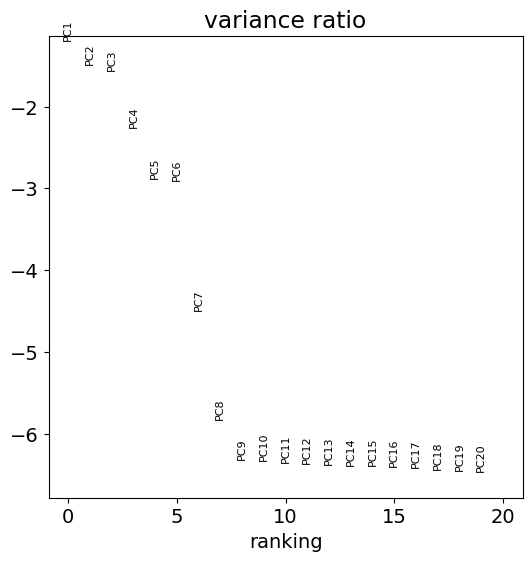

In [141]:
# Calculate the visualizations
plt.rcParams['figure.figsize']=(6,6) #rescale figures

n_pcs=20
sc.pp.pca(adata, n_comps=n_pcs, use_highly_variable=True, svd_solver='arpack',random_state=42)
sc.pl.pca_variance_ratio(adata,n_pcs, log=True)


# How many clusters seem to be there?
# hint: *broad* clusters, use  resolution<0.3
# hint: denpending on your random seed, the number might change by 1 or 2
### **12/**4/21/2

In [149]:
sc.pp.neighbors(adata,n_pcs=8,random_state=42, metric='euclidean')
sc.tl.umap(adata,random_state=42)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


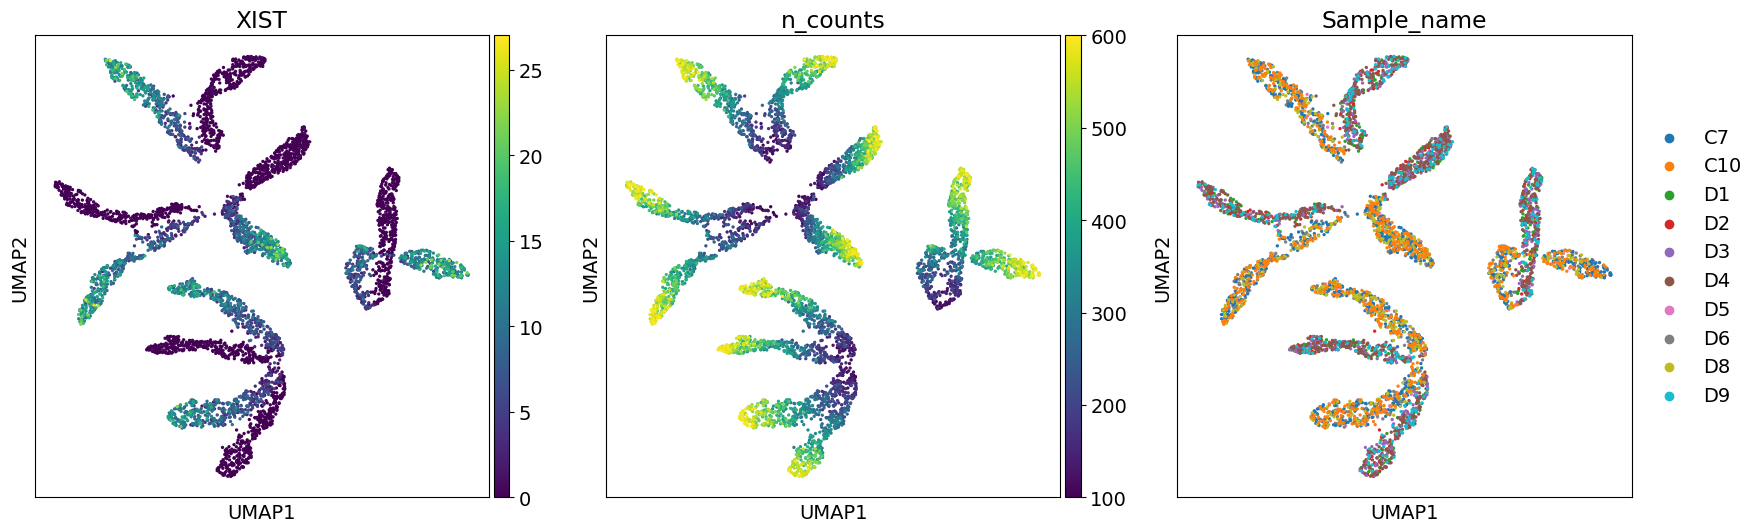

In [150]:
#sc.pl.pca_scatter(adata, color='XIST')
sc.pl.umap(adata, color=['XIST','n_counts','Sample_name'])

In [156]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, resolution=0.2, key_added='louvain_r0.2', random_state=42)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


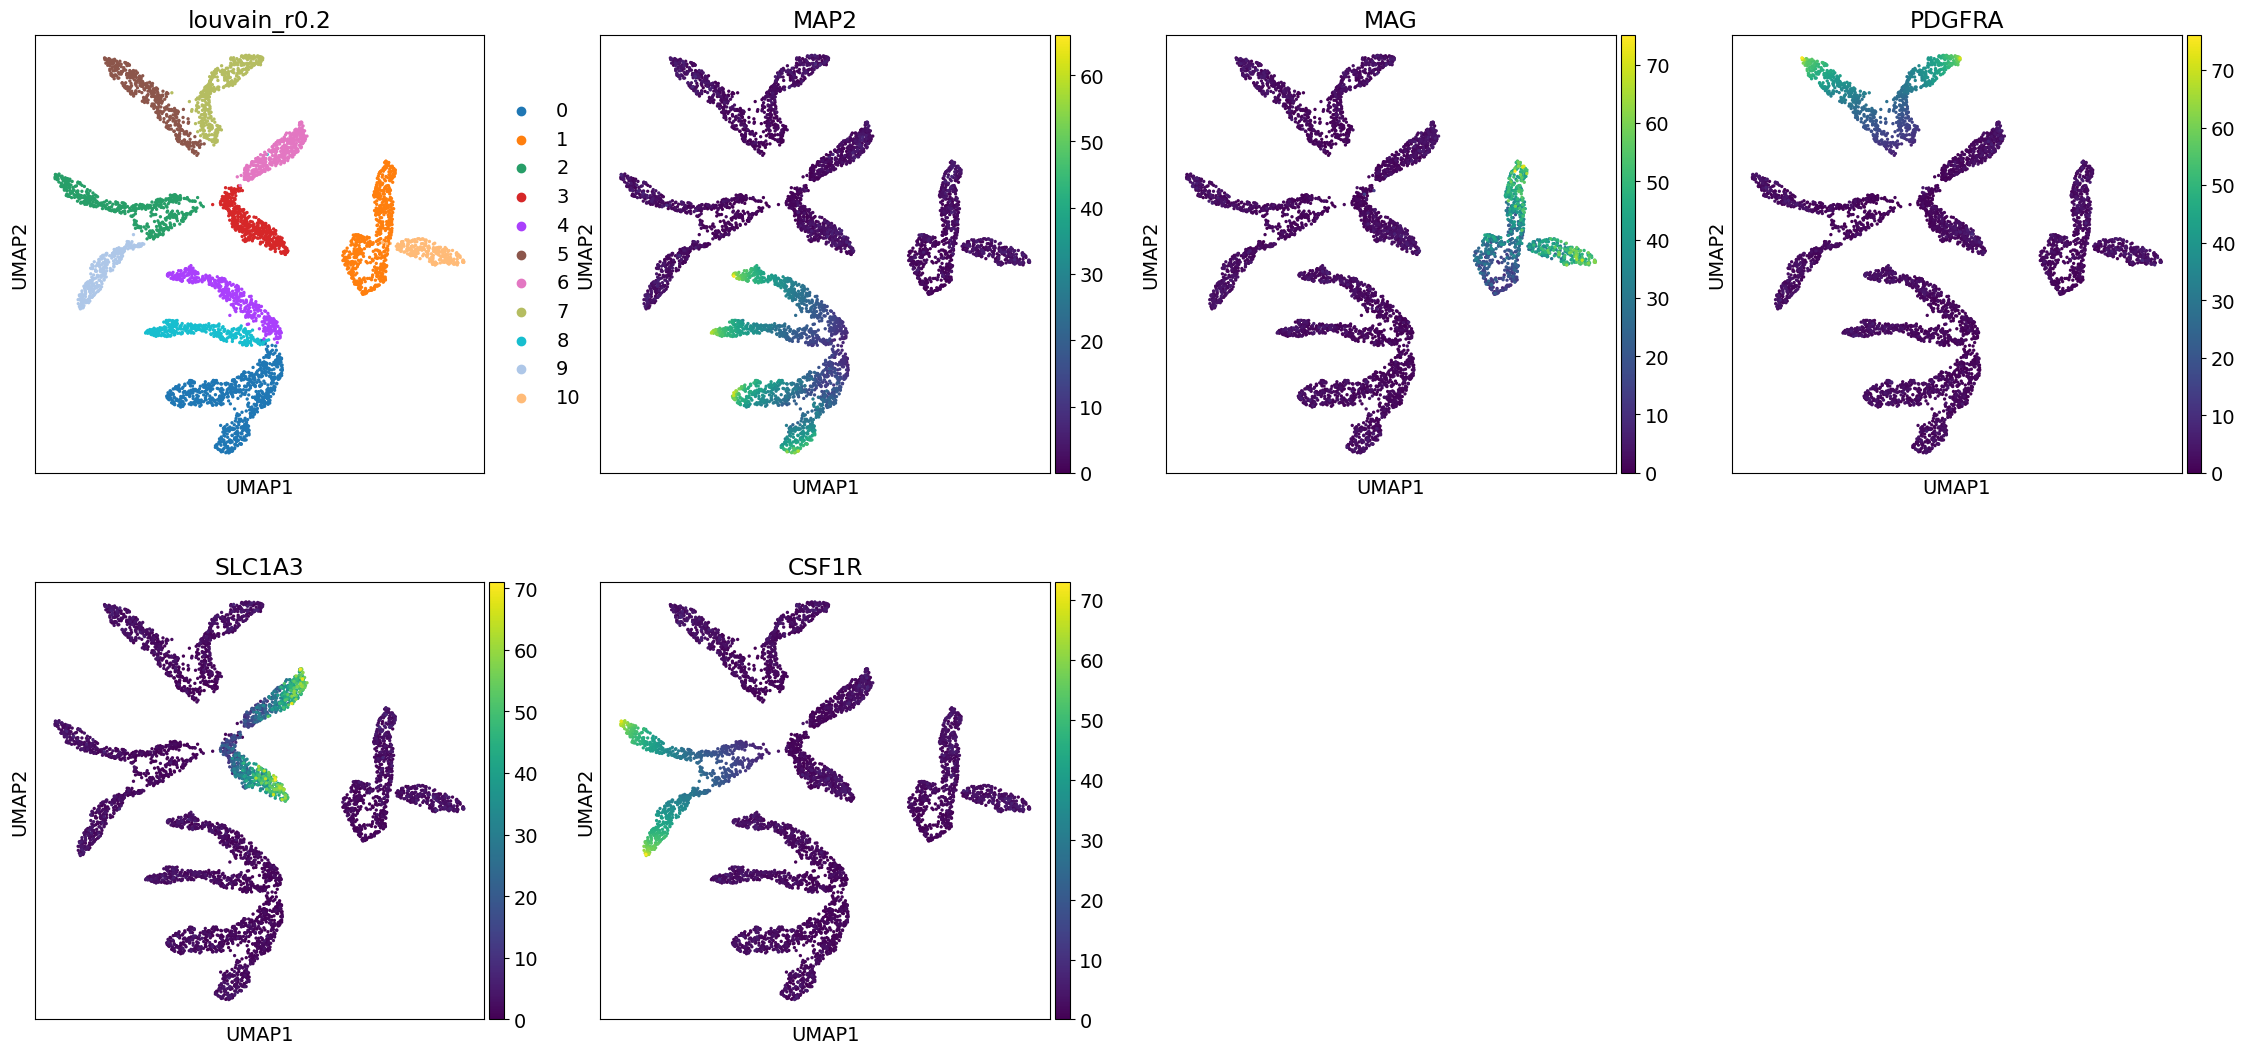

In [157]:
sc.pl.umap(adata, color=['louvain_r0.2','MAP2','MAG','PDGFRA','SLC1A3','CSF1R'])

# How many cells types seem to be there?
# hint: check the dendrogram, see which genes are actually type markers
### 11/2/**6/**24

In [158]:
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.2', key_added='DE_02',method='wilcoxon',pts=True)


In [159]:
sc.tl.dendrogram(adata,groupby='louvain_r0.2')

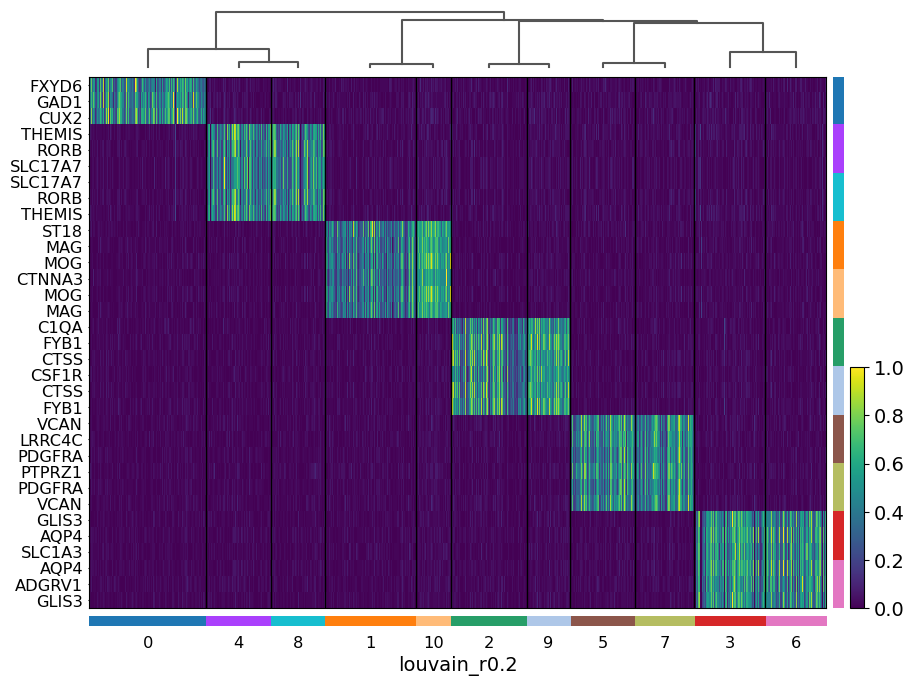

In [161]:
plt.rcParams.update({'font.size': 14})

sc.pl.rank_genes_groups_heatmap(adata, n_genes=3,
                                standard_scale='var',
                                groupby='louvain_r0.2',key='DE_02',
                                swap_axes=True,
                                figsize=(10,8),
                                show_gene_labels=True,
                                dendrogram=True)

# What is the largest difference between the subjects?
# hint: you can check the distribution of QC features by subject with sc.pl.violin
# hint: you can do differential expression by subject with sc.tl.rank_genes_groups
### QC features/**sex/**cell type content/age

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


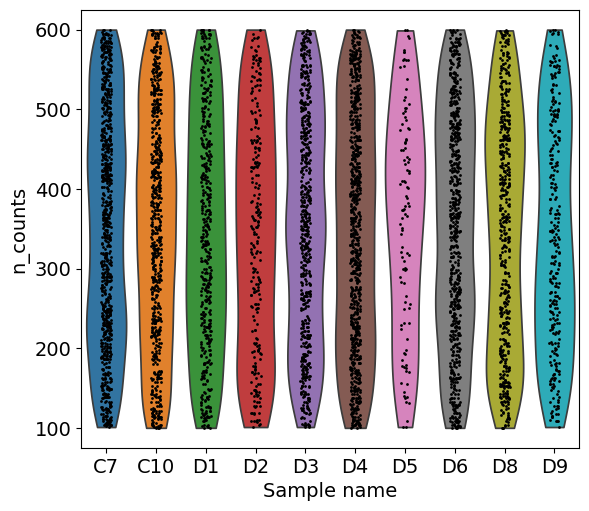

In [162]:
sc.pl.violin(adata, 'n_counts', groupby='Sample_name', size=2, log=False);

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


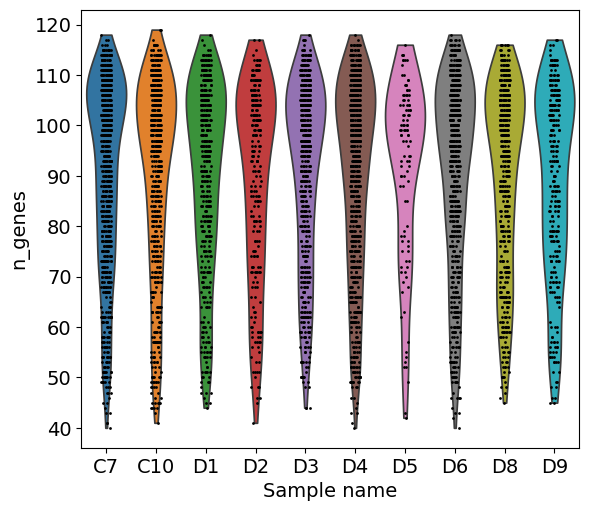

In [163]:
sc.pl.violin(adata, 'n_genes', groupby='Sample_name', size=2, log=False);

In [166]:
sc.tl.rank_genes_groups(adata, groupby='Sample_name', key_added='DE_Sample',method='wilcoxon',pts=True)


In [167]:
sc.tl.dendrogram(adata,groupby='Sample_name')

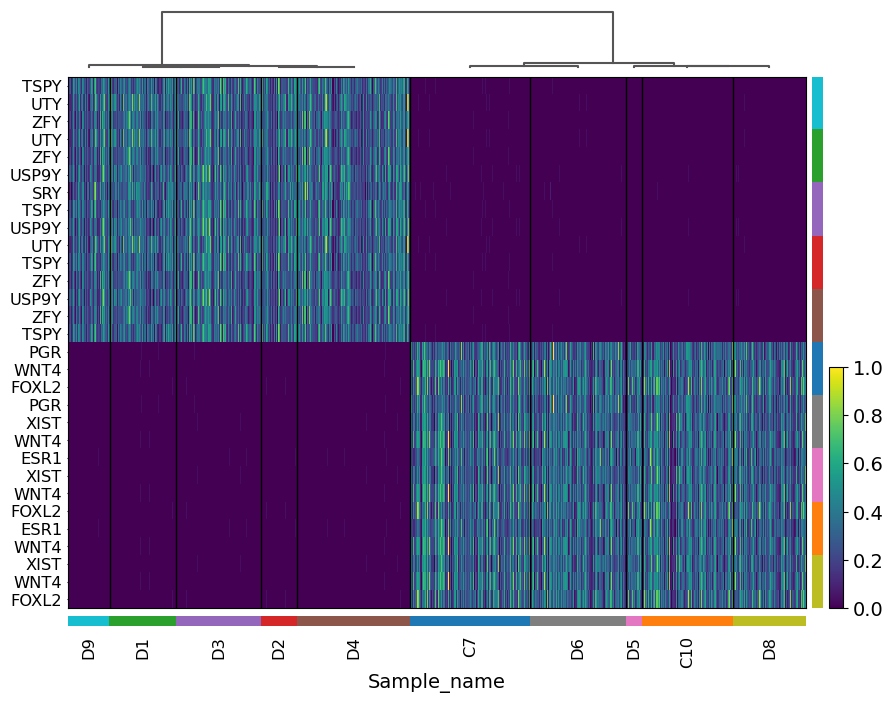

In [168]:
plt.rcParams.update({'font.size': 14})

sc.pl.rank_genes_groups_heatmap(adata, n_genes=3,
                                standard_scale='var',
                                groupby='Sample_name',key='DE_Sample',
                                swap_axes=True,
                                figsize=(10,8),
                                show_gene_labels=True,
                                dendrogram=True)

# How many subjects are female?
# hint: look for high expression of female-linked genes and low Y-linked genes expression
### 1/12/7/**5**